### For Images

In [10]:
from requests import exceptions
import requests
import cv2
import dlib
from matplotlib import pyplot as plt
import uuid
import urllib.request
import numpy as np

(193, 292, 3)


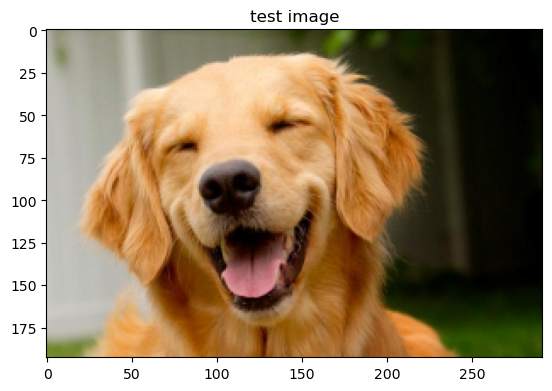

In [2]:
url = "https://gcdn.emol.cl/mascotas/files/2018/03/perro-raro.jpg"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)            
#image = cv2.imread("charizard.png")
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.title("test image")
plt.imshow(image)    
print(image.shape)

### Raw Pixel Feature Vectors

In [3]:
raw = image.flatten()
print(raw.shape)
print(raw)

(169068,)
[172 172 160 ...  44  74   1]


### Color Mean and Standard Deviation

In [4]:
means = cv2.mean(image)
means = means[:3]
(means, stds) = cv2.meanStdDev(image)
stats = np.concatenate([means, stds]).flatten()
print(stats)

[129.24169565 103.20310171  67.95815885  83.25788436  68.50146879
  65.03413215]


### Color Histograms (3D color histogram)

What is the expected output of my image descriptor? A list of numbers used to characterize the color distribution of the image.
Here we have a 3D histogram with 8 bins per channel. Let’s examine the shape of our histogram:

cv2.calcHist(images, channels, mask, histSize, ranges)

1. images: This is the image that we want to compute a histogram for. Wrap it as a list: [myImage].
channels: A list of indexes, where we specify the index of the channel we want to compute a histogram for. To compute a histogram of a grayscale image, the list would be [0]. To compute a histogram for all three red, green, and blue channels, the channels list would be [0, 1, 2].
2. mask: I haven’t covered masking yet in this blog yet, but essentially, a mask is a uint8  image with the same shape as our original image, where pixels with a value of zero are ignored and pixels with a value greater than zero are included in the histogram computation. Using masks allow us to only compute a histogram for a particular region of an image. For now, we’ll just use a value of None for the mask.
3. histSize: This is the number of bins we want to use when computing a histogram. Again, this is a list, one for each channel we are computing a histogram for. The bin sizes do not all have to be the same. Here is an example of 32 bins for each channel: [32, 32, 32].
4. ranges: The range of possible pixel values. Normally, this is [0, 256] for each channel, but if you are using a color space other than RGB (such as HSV), the ranges might be different.

flattened feature vector size: 768


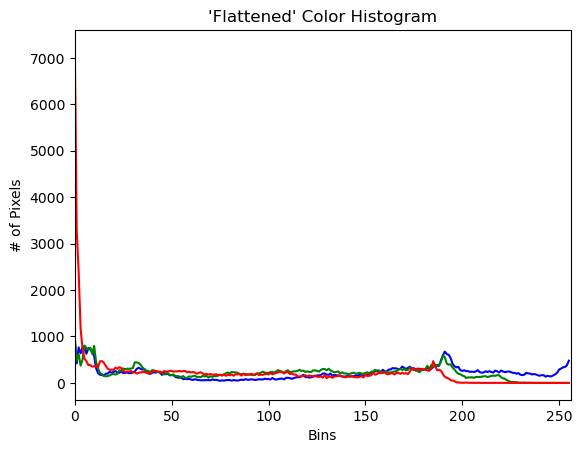

In [5]:
chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
features = []
 
# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist) 
    # plot the histogram
    plt.plot(hist, color = color)
    plt.xlim([0, 256])
 
# here we are simply showing the dimensionality of the
# flattened color histogram 256 bins for each channel
# x 3 channels = 768 total values -- in practice, we would
# normally not use 256 bins for each channel, a choice
# between 32-96 bins are normally used, but this tends
# to be application dependent
print("flattened feature vector size: %d" % (np.array(features).flatten().shape))

## For audio

Following through this example, you'll learn how to:

1. Load audio input
2. Compute mel spectrogram, MFCC, delta features, chroma
3. Locate beat events
4. Compute beat-synchronous features
5. Display features
6. Save beat tracker output to a CSV file

In [1]:
# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
%matplotlib inline
# and IPython.display for audio output
import IPython.display
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

In [7]:
!curl https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/LightOff.wav -o LightOff.wav 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     74      0 --:--:-- --:--:-- --:--:--    75


In [8]:
!ls

algorithms  cmd  Dockerfile  features-extraction.ipynb	LightOff.wav  run.sh


In [9]:
!pwd

/home/jovyan


In [5]:
!ffmpeg -version

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/aarch64-linux-gnu --incdir=/usr/include/aarch64-linux-gnu --arch=arm64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable

In [7]:
filename = librosa.example('nutcracker')

In [8]:
y, sr = librosa.load(filename)
IPython.display.Audio(filename, autoplay=False)

/tmp/ipykernel_68/193697975.py:2: FutureWarning: Pass y=[ 2.2716843e-06  5.3327230e-06 -7.2473276e-06 ...  1.1170752e-05
  1.2871882e-06  5.4120646e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)


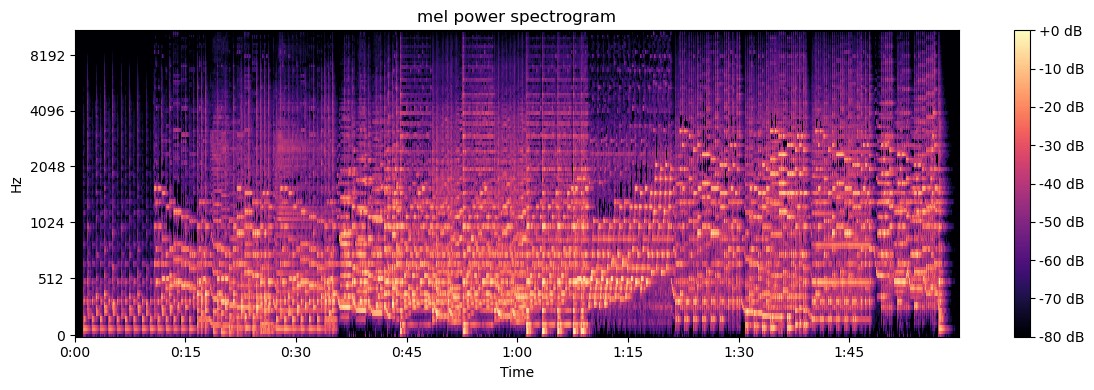

In [11]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

In [12]:
S

array([[1.16246604e-11, 2.98008450e-12, 2.64095402e-18, ...,
        9.72520137e-16, 3.66933724e-13, 2.91554385e-11],
       [1.21081166e-11, 3.10386352e-12, 2.16653740e-18, ...,
        1.72506476e-15, 3.66190693e-13, 3.00455841e-11],
       [1.22711442e-11, 3.14083243e-12, 2.59693291e-18, ...,
        1.86517417e-15, 3.81810984e-13, 3.05197048e-11],
       ...,
       [1.04173371e-10, 4.39319171e-11, 2.70095724e-10, ...,
        2.39921025e-08, 3.48669289e-08, 2.32856063e-08],
       [5.70053471e-09, 8.75150707e-09, 1.38748630e-08, ...,
        3.10395691e-08, 2.10439275e-08, 1.60568145e-08],
       [1.98135179e-08, 3.96298105e-08, 3.93094481e-08, ...,
        2.96756735e-08, 2.01046948e-08, 1.28062787e-08]], dtype=float32)

### Harmonic-percussive source separation
Before doing any signal analysis, let's pull apart the harmonic and percussive components of the audio. This is pretty easy to do with the effects module.

In [13]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

/tmp/ipykernel_68/1432306911.py:3: FutureWarning: Pass y=[ 9.6558767e-07  1.9192139e-06 -2.4968751e-06 ...  7.1187264e-06
 -5.8214482e-06  1.4830514e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
/tmp/ipykernel_68/1432306911.py:4: FutureWarning: Pass y=[ 1.3060969e-06  3.4135091e-06 -4.7504527e-06 ...  4.0520254e-06
  7.1086356e-06  3.9290135e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)


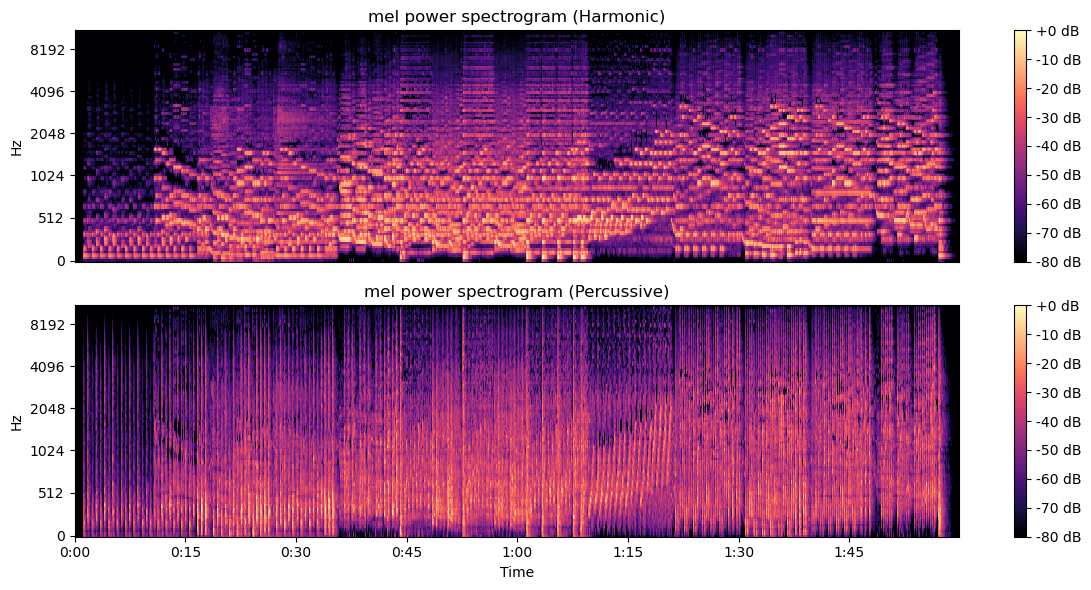

In [14]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

### Chromagram
Next, we'll extract Chroma features to represent pitch class information.

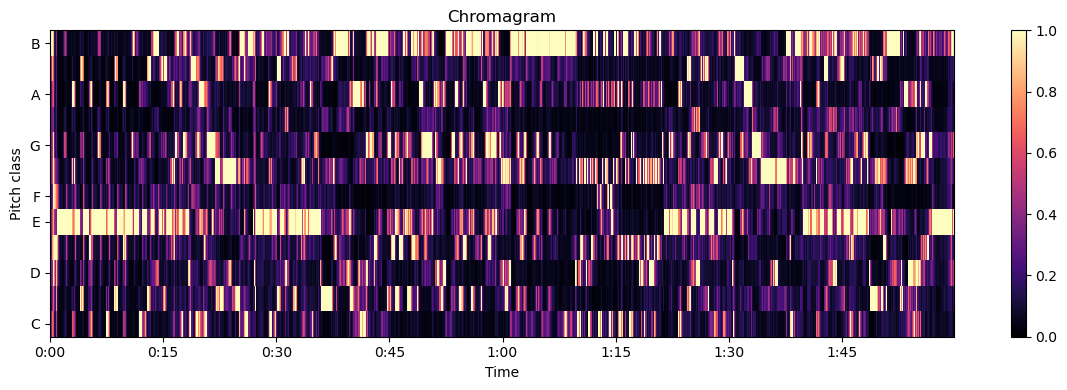

In [15]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

### MFCC
Mel-frequency cepstral coefficients are commonly used to represent texture or timbre of sound.

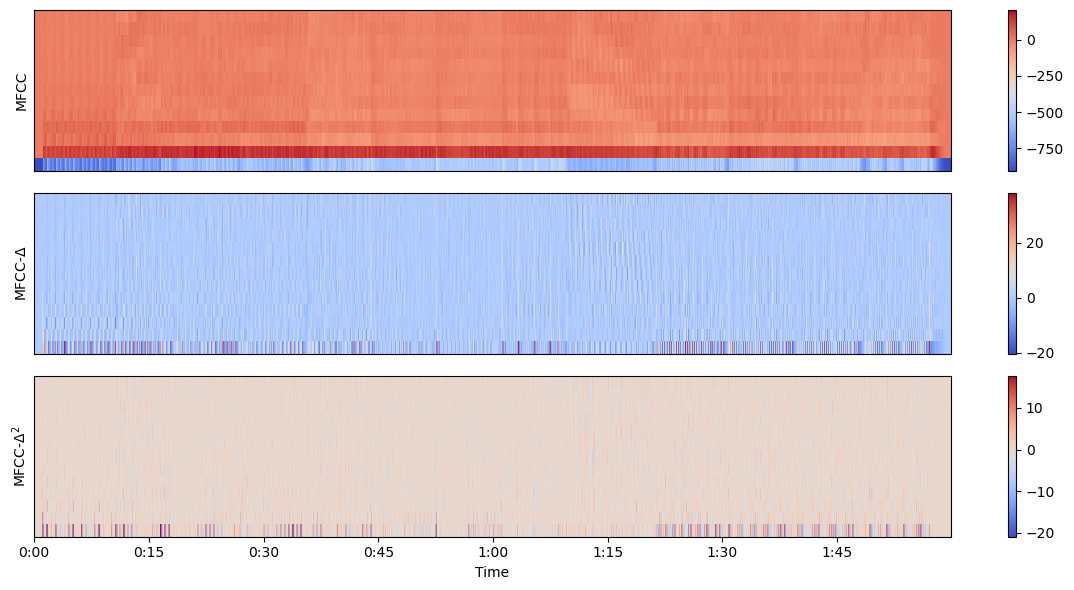

In [16]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)
# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction

## For Text

Text data requires special preparation before you can start using it for predictive modeling.
The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).
The scikit-learn library offers easy-to-use tools to perform both tokenization and feature extraction of your text data.
You'll learn :
1. How to convert text to word count vectors with CountVectorizer.
2. How to convert text to word frequency vectors with TfidfVectorizer.
3. How to convert text to unique integers with HashingVectorizer.

## Bag-of-Words Model

We cannot work with text directly when using machine learning algorithms.
Instead, we need to convert the text to numbers.
We may want to perform classification of documents, so each document is an “input” and a class label is the “output” for our predictive algorithm. Algorithms take vectors of numbers as input, therefore we need to convert documents to fixed-length vectors of numbers.
A simple and effective model for thinking about text documents in machine learning is called the Bag-of-Words Model, or BoW.

### Word Counts With CountVectorizer

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.
Because these vectors will contain a lot of zeros, we call them sparse. Python provides an efficient way of handling sparse vectors in the scipy.sparse package.

We can see that all words were made lowercase by default and that the punctuation was ignored. These and other aspects of tokenizing can be configured and I encourage you to review all of the options in the API documentation.

Running the example first prints the vocabulary, then the shape of the encoded document. We can see that there are 8 words in the vocab, and therefore encoded vectors have a length of 8.

We can then see that the encoded vector is a sparse matrix. Finally, we can see an array version of the encoded vector showing a count of 1 occurrence for each word except the (index and id 7) that has an occurrence of 2.


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())


{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse._csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


Running this example prints the array version of the encoded sparse vector showing one occurrence of the one word in the vocab and the other word not in the vocab completely ignored.
The encoded vectors can then be used directly with a machine learning algorithm.

In [18]:
text2 = ["the puppy"]
vector = vectorizer.transform(text2)
print(vector.toarray())

[[0 0 0 0 0 0 0 1]]


### Word Frequencies with TfidfVectorizer

Word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

1. Term Frequency: This summarizes how often a given word appears within a document.
2. Inverse Document Frequency: This downscales words that appear a lot across documents.

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents. Alternately, if you already have a learned CountVectorizer, you can use it with a TfidfTransformer to just calculate the inverse document frequencies and start encoding documents.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog.",
    "The dog.",
    "The fox"]
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
[1.69314718 1.28768207 1.28768207 1.69314718 1.69314718 1.69314718
 1.69314718 1.        ]
(1, 8)
[[0.36388646 0.27674503 0.27674503 0.36388646 0.36388646 0.36388646
  0.36388646 0.42983441]]


A vocabulary of 8 words is learned from the documents and each word is assigned a unique integer index in the output vector.
The inverse document frequencies are calculated for each word in the vocabulary, assigning the lowest score of 1.0 to the most frequently observed word: “the” at index 7.

Finally, the first document is encoded as an 8-element sparse array and we can review the final scorings of each word with different values for “the“, “fox“, and “dog” from the other words in the vocabulary.

The scores are normalized to values between 0 and 1 and the encoded document vectors can then be used directly with most machine learning algorithms.

### Hashing with HashingVectorizer

Counts and frequencies can be very useful, but one limitation of these methods is that the vocabulary can become very large.

This, in turn, will require large vectors for encoding documents and impose large requirements on memory and slow down algorithms.

A clever work around is to use a one way hash of words to convert them to integers. The clever part is that no vocabulary is required and you can choose an arbitrary-long fixed length vector. A downside is that the hash is a one-way function so there is no way to convert the encoding back to a word (which may not matter for many supervised learning tasks).

An arbitrary fixed-length vector size of 20 was chosen. This corresponds to the range of the hash function, where small values (like 20) may result in hash collisions. Remembering back to compsci classes, I believe there are heuristics that you can use to pick the hash length and probability of collision based on estimated vocabulary size.

Note that this vectorizer does not require a call to fit on the training data documents. Instead, after instantiation, it can be used directly to start encoding documents.

In [20]:
from sklearn.feature_extraction.text import HashingVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = HashingVectorizer(n_features=20)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(1, 20)
[[ 0.          0.          0.          0.          0.          0.33333333
   0.         -0.33333333  0.33333333  0.          0.          0.33333333
   0.          0.          0.         -0.33333333  0.          0.
  -0.66666667  0.        ]]


Running the example encodes the sample document as a 20-element sparse array.
The values of the encoded document correspond to normalized word counts by default in the range of -1 to 1, but could be made simple integer counts by changing the default configuration.

## For Faces

In [47]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import math

In [25]:
!curl "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2" -o shape_predictor_68_face_landmarks.dat.bz2 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61.0M  100 61.0M    0     0  3413k      0  0:00:18  0:00:18 --:--:-- 2459k


In [31]:
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2 

In [32]:
LANDMARK_MODEL = "shape_predictor_68_face_landmarks.dat"

In [53]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y 
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype) 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y) 
    # return the list of (x, y)-coordinates
    return coords

def display(images = [], cols = 1):
    n_images = len(images)
    titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    cols = cols 
    rows = math.ceil(n_images / cols)
    for n, (image, title) in enumerate(zip(images, titles)):
        # Number of columns in figure (number of rows is set to np.ceil(n_images/float(cols))).
        a = fig.add_subplot(rows, cols, n+1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [33]:
print(LANDMARK_MODEL)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(LANDMARK_MODEL)

shape_predictor_68_face_landmarks.dat


(175, 295, 3)


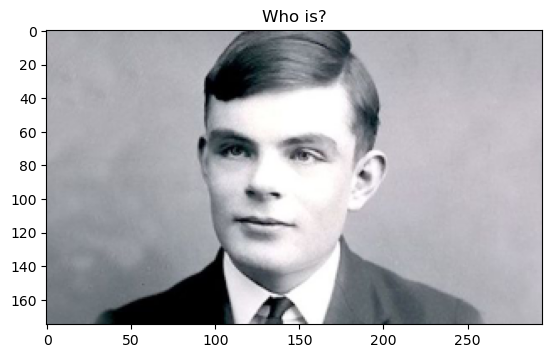

In [34]:
url = "https://goo.gl/eLpSEV"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)            
#image = cv2.imread("charizard.png")
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw = image.copy()
plt.figure()
plt.title("Who is?")
plt.imshow(image)    
print(image.shape)

In [35]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)

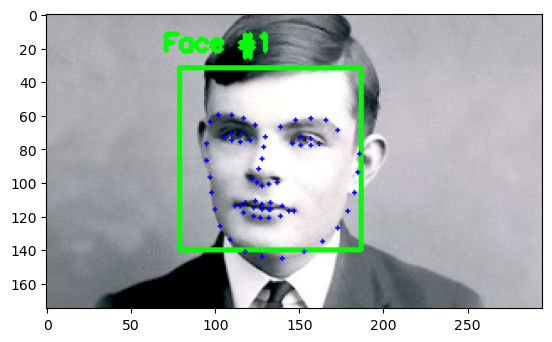

In [38]:

# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape) 
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(draw, (x, y), (x + w, y + h), (0, 255, 0), 2) 
    # show the face number
    cv2.putText(draw, "Face #{}".format(i + 1), (x - 10, y - 10)
                ,cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2) 
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(draw, (x, y), 1, (0, 0, 255), -1) 
# show the output image with the face detections + facial landmarks
#cv2.imshow("Output", image)
#cv2.waitKey(0)
plt.imshow(draw)    

mouth
inner_mouth
right_eyebrow
left_eyebrow
right_eye
left_eye
nose
jaw


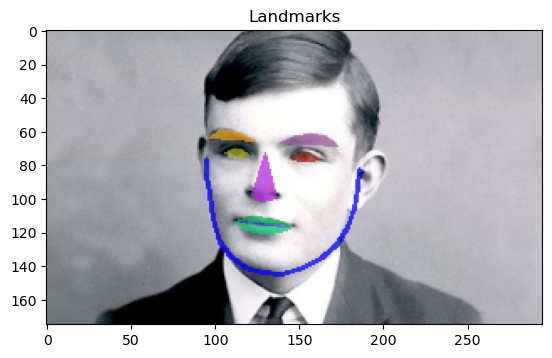

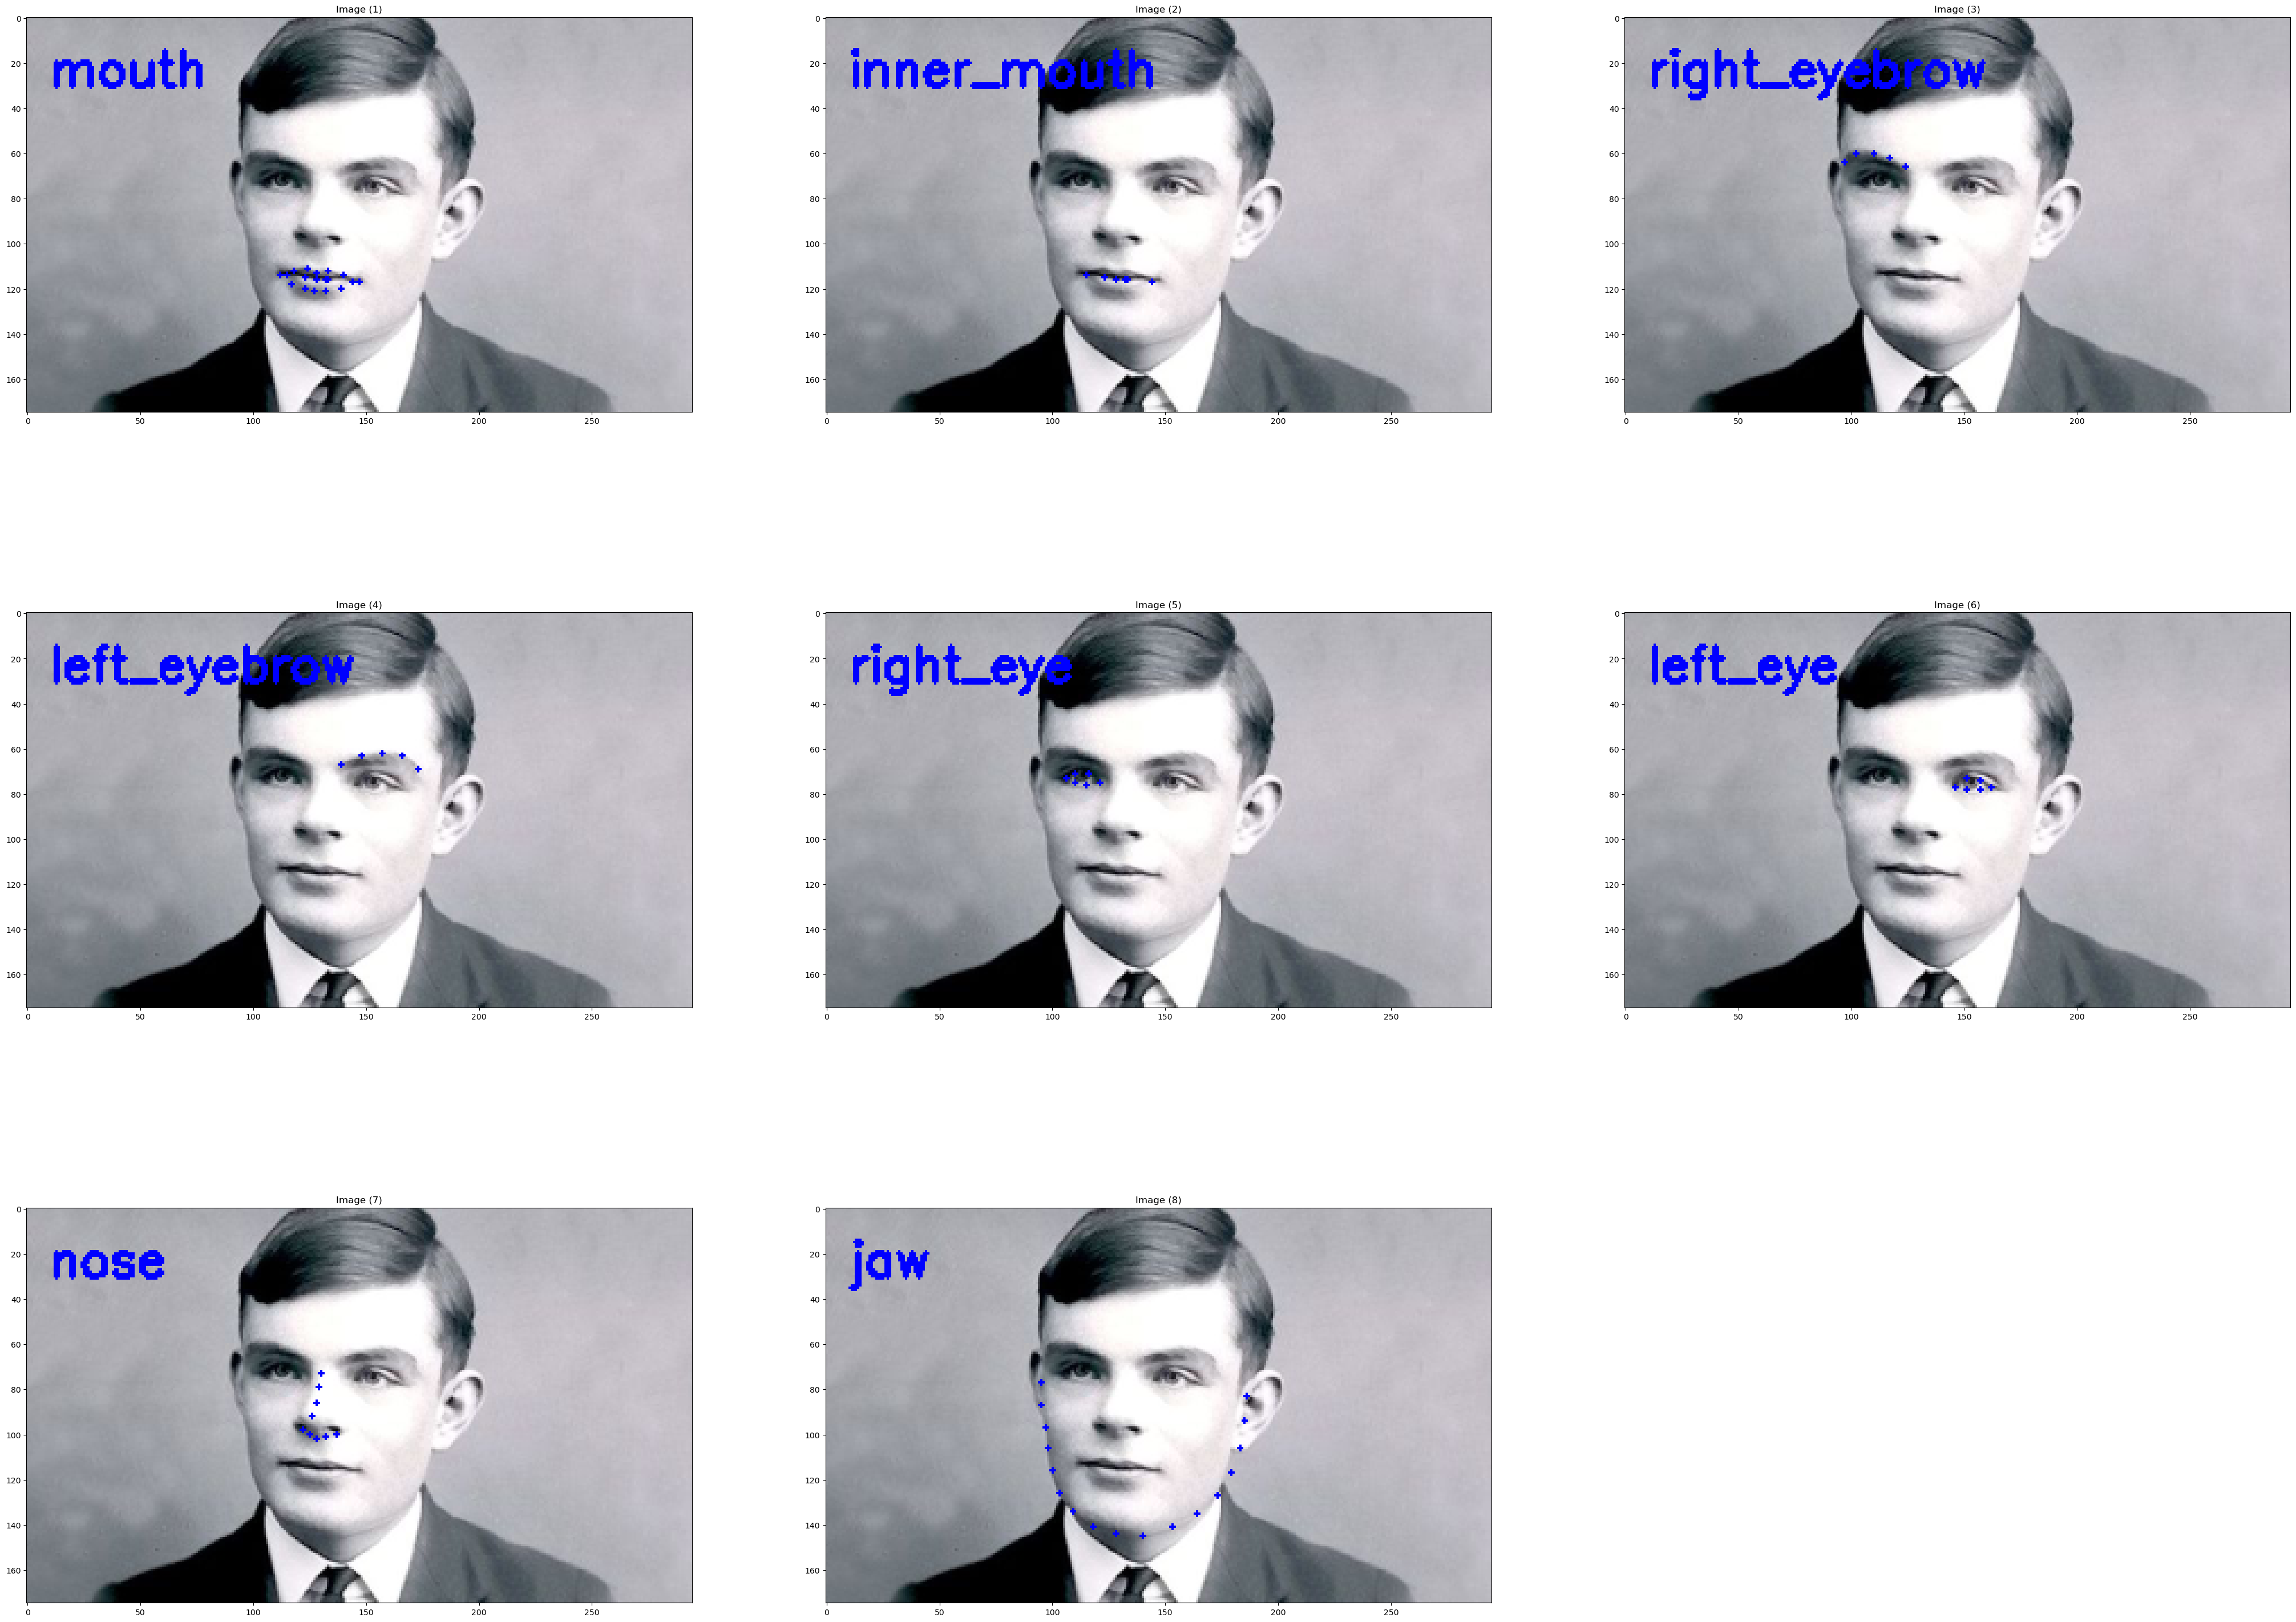

In [54]:
def draw_individual_detections(image, detector, predictor):
    X = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # loop over the face parts individually
        for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
            # clone the original image so we can draw on it, then
            # display the name of the face part on the image
            print(name)
            clone = image.copy()
            cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (0, 0, 255), 2)

            # loop over the subset of facial landmarks, drawing the
            # specific face part
            for (x, y) in shape[i:j]:
                cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)

            # extract the ROI of the face region as a separate image
            (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
            roi = image[y:y + h, x:x + w]
            roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)

            # show the particular face part
            #cv2.imshow("ROI", roi)
            #cv2.imshow("Image", clone)
            #cv2.waitKey(0)
            X.append(clone)
            

        # visualize all facial landmarks with a transparent overlay
        output = face_utils.visualize_facial_landmarks(image, shape)
        plt.figure()
        plt.title("Landmarks")
        plt.imshow(output)
    return X
        
X = draw_individual_detections(image, detector, predictor)
display(X, 3)